In [4]:
import gensim 
import pandas as pd
import logging
import math
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
import random

## Preprocessing and feature engineering

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/IS/Playlist Generation')

In [5]:
songs = pd.read_csv('spotify_dataset.csv', header=None, skiprows=[0], usecols=[0,1,2,3]).dropna()
songs.columns = ['user_id', 'artistname','trackname','playlistname']

In [6]:
display(songs.shape)
display(songs['trackname'].nunique())

(12867130, 4)

2009209

In [7]:
print(songs[songs['artistname'] == 'Pink Floyd'].trackname[0:20].to_string())

896                                         Sorrow - Live
1057                                     Comfortably Numb
1058                              Comfortably Numb - Live
1098                     Echoes - 2011 Remastered Version
1099                    Eclipse - 2011 Remastered Version
1186                                       Hey You - Live
1187                                    High Hopes - Live
1414                    Shine On You Crazy Diamond - Live
1554     Welcome To The Machine - 2011 Remastered Version
1568                 Wish You Were Here - 2011 - Remaster
4193               Brain Damage - 2011 Remastered Version
5123               Echoes - Edit; 2001 Remastered Version
5353                   Fearless - 2011 Remastered Version
7647                      Money - 2011 Remastered Version
10929                                  Wish You Were Here
10930                Wish You Were Here - 2011 - Remaster
11229              Brain Damage - 2011 Remastered Version
12235         

In [8]:
#Every artist can have only one version of the song, reduces unique songs from 2009210 to 1367548

def preprocess_track(trackname):

    trackname = trackname.lower()
    
    # everything between [], () is often live remaster etc.
    trackname = re.sub("[\(\[].*?[\)\]]", "", trackname)
        
    #Remove everything after '-' as they most likely are live, remastered, year etc identifiers
    trackname = trackname.split('-', 1)[0]
    #Remove empty spaces around the trackname
    trackname = trackname.strip()     
       
    return trackname

In [9]:
songs['trackname'] = songs['trackname'].copy().apply(preprocess_track)
#Alternatively only song names to lowercase
#songs['trackname'] = songs['trackname'].map(lambda x: x.lower())
songs['artistname'] = songs['artistname'].map(lambda x: x.lower())

In [10]:
#uniques after preprocessing
songs['trackname'].nunique()

1367547

In [11]:
print(songs[songs['artistname'] == 'pink floyd'].trackname[0:20].to_string())

896                          sorrow
1057               comfortably numb
1058               comfortably numb
1098                         echoes
1099                        eclipse
1186                        hey you
1187                     high hopes
1414     shine on you crazy diamond
1554         welcome to the machine
1568             wish you were here
4193                   brain damage
5123                         echoes
5353                       fearless
7647                          money
10929            wish you were here
10930            wish you were here
11229                  brain damage
12235                         money
12809                         money
28819                one of the few


In [12]:
#Make two new features
#trackartist: identifty the spesific track of the artist to differ between same named songs from different artist (meta2prodvec)
songs["trackartist"] = songs["artistname"] + " - " +songs["trackname"]
#userplaylist to differ between playlists named the same
songs["userplaylist"] = songs["user_id"] + " - " +songs["playlistname"]

In [13]:
songs.head()

user_id  ...                                       userplaylist
0  9cc0cfd4d7d7885102480dd99e7a90d6  ...  9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
1  9cc0cfd4d7d7885102480dd99e7a90d6  ...  9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
2  9cc0cfd4d7d7885102480dd99e7a90d6  ...  9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
3  9cc0cfd4d7d7885102480dd99e7a90d6  ...  9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010
4  9cc0cfd4d7d7885102480dd99e7a90d6  ...  9cc0cfd4d7d7885102480dd99e7a90d6 - HARD ROCK 2010

[5 rows x 6 columns]

In [14]:
#large increase in unique songs when artist names added to song name
songs['trackartist'].nunique()

2342853

In [15]:
frequency_of_songs = songs.groupby('trackartist').count()['user_id']
sorted_frequencies = frequency_of_songs.sort_values(ascending=False)

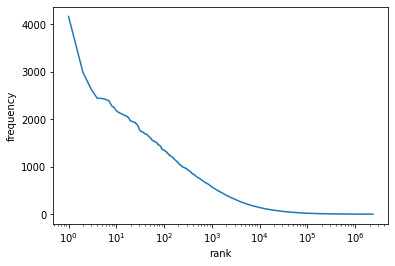

In [16]:
plt.plot(np.arange(1,2342854),sorted_frequencies[0:2342855])
plt.ylabel('frequency')
plt.xlabel('rank')
plt.xscale('log')

plt.show()

In [17]:
#min count hyperparameter 5 chosen to take into the model most of the songs 
display(np.sum(sorted_frequencies[0:400000]))
display(sorted_frequencies[400000])

9837225

5

In [18]:
#Remove playlist with less than 10 tracks and combine into lists
playlists = songs.groupby(['userplaylist']).filter(lambda x: len(x) >= 10)
playlists = playlists.groupby(['userplaylist']).agg({'trackartist':lambda x: list(x)})

In [19]:
display(playlists.head())
display(playlists.shape)

trackartist
userplaylist                                                                                   
00055176fea33f6e027cd3302289378b - favs       [jannik brunke - 18, green day - 21 guns, shaw...
0007f3dd09c91198371454c608d47f22 - Fav songs  [bryan adams - i do it for you, colourshop - 2...
000b0f32b5739f052b9d40fcc5c41079 - Contacta   [veronica maggio - bas gillar hörn, titiyo - b...
000b0f32b5739f052b9d40fcc5c41079 - Gospel     [the worship crew - brighter day, oslo gospel ...
000b0f32b5739f052b9d40fcc5c41079 - Starred    [java gospel - a blessed christmas eve, java g...

(188437, 1)

In [20]:
def playlist_format(playlists):
    documents = []
    for index, row in playlists.iterrows():
        preprocessed_songs = row['trackartist']
        documents.append(preprocessed_songs)

    return documents    

In [21]:
playlist_formatted = playlist_format(playlists)
playlist_length = len(playlist_formatted)
print(playlist_length)

188437


## Training Word2vec-music recommender

In [22]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [23]:
np.random.seed(0)

In [24]:
#Train with 80 % of the data (with cross validation) and test the final model with 20% of the data
#train/test split for spotify playlist
index = np.random.choice(range(playlist_length), playlist_length, replace=False)
train = np.array(playlist_formatted)[index[:int(playlist_length * 0.8)]].tolist()
test = np.array(playlist_formatted)[index[int(playlist_length * 0.8):]].tolist()

In [25]:
# #train/test split for shopping baskets
# index = np.random.choice(range(baskets_length), baskets_length, replace=False)
# train = np.array(baskets)[index[:int(baskets_length * 0.8)]].tolist()
# test = np.array(baskets)[index[int(baskets_length * 0.8):]].tolist()

In [26]:
#Help:
#https://github.com/manasRK/word2vec-recommender/blob/master/semsim_train.py
#https://arxiv.org/abs/1804.04212
#http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
#https://stackoverflow.com/questions/38287772/cbow-v-s-skip-gram-why-invert-context-and-target-words

### Evaluation

In [27]:
def test_HR_and_NDGC_single_item(playlist, index, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    query = playlist[index]
    word = playlist[index+1]
    try:
        res = model.wv.most_similar(positive=query, topn=k)
        for i in range(k):
            if res[i][0] == word:
                hits += 1
                ndgc += 1/(math.log2(i+1))
        tries += 1
    except:
        fails += 1
        #print(query + " was not found in vocab")
    return (hits, ndgc, tries, fails)

# slow and not same task as in the paper 
def test_HR_and_NDGC_whole_test_set(test_set, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    for playlist in test_set:
        #ind = random.randrange(len(playlist)-1)
        for ind in range(len(playlist)-1):
            hi, nd, tr, fa = test_HR_and_NDGC_single_item(playlist, ind, k)
            hits+=hi
            ndgc+=nd
            tries+=tr
            fails+=fa
    return (hits, ndgc, tries, fails)

def test_HR_and_NDGC_one_task_per_playlist(test_set, k):
    hits = 0
    ndgc = 0
    tries = 0
    fails = 0
    for playlist in test_set:
        ind = random.randrange(len(playlist)-1)
        hi, nd, tr, fa = test_HR_and_NDGC_single_item(playlist, ind, k)
        hits+=hi
        ndgc+=nd
        tries+=tr
        fails+=fa
    return (hits, ndgc, tries, fails)

### Gridsearch

In [ ]:
def grid_search(*iterables):
    #create all combinations of input values
    return np.array(np.meshgrid(*iterables)).T.reshape(-1,len(iterables))

workers = 12
k=10 #predicted items
sg=0 #0 for cbow 1 for skipgram

window_options = [3, 5, 7, 9] #window size L
it_options = [5, 25,100] #epochs n
sample_options = [0.1, 0.001, 0.00001] #sub-sampling t 
negative_sampling_dist = [-0.5, 0.75] # negative sampling distribution parameter a

size_embedding_options = [50] # embedding size
neg_options = [5] #negative samples amount
alpha = [0.025] # learning rate
min_count_options = [5] #words under this are ignored
   
hyperparameters = []
hit_ratios = []
NDCG = []
best_model = None



for (n_window, n_it, n_sample, n_neg_sample_dist, n_size, n_neg, n_alpha, n_min_count) in \
        grid_search(window_options, it_options, sample_options, negative_sampling_dist, size_embedding_options,
                    neg_options, alpha,min_count_options):
    hyperparameters.append([n_window, n_it, n_sample, n_neg_sample_dist, n_size, n_neg, n_alpha, n_min_count])
    print('Using following hyperparameters: ', hyperparameters[-1])
    model = gensim.models.Word2Vec(train, size=int(n_size), window=int(n_window),
                 min_count=int(n_min_count), workers=workers, sg=sg, iter=int(n_it),
                 sample=n_sample, negative=int(n_neg), ns_exponent=n_neg_sample_dist, alpha=n_alpha)
    
    model.train(train,total_examples=len(train), epochs=model.iter)
    hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_playlist(test, k)
    hit_ratio = hits/tries
    if hit_ratios and hit_ratio > max(hit_ratios):
        best_model = model
    hit_ratios.append(hits/tries)
    NDCG.append(ndgc/tries)
    print('Accuracy (hit_ratio) values for parameters:', hits/tries)
    print('NDCG values for parameters:', ndgc/tries)

2020-09-14 16:17:06,979 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-09-14 16:17:06,981 : INFO : collecting all words and their counts
2020-09-14 16:17:06,981 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Using following hyperparameters:  [3.0, 5.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-14 16:17:07,335 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-14 16:17:07,740 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-14 16:17:08,147 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-14 16:17:08,557 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-14 16:17:08,954 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-14 16:17:09,368 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-14 16:17:09,761 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-14 16:17:10,237 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-14 16:17:10,631 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

Accuracy (hit_ratio) values for parameters: 0.022261005841287932
NDCG values for parameters: 0.008587297746645668
Using following hyperparameters:  [3.0, 25.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-14 16:29:17,475 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-14 16:29:17,994 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-14 16:29:18,511 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-14 16:29:19,010 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-14 16:29:19,481 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-14 16:29:19,954 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-14 16:29:20,398 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-14 16:29:20,934 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-14 16:29:21,345 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

Accuracy (hit_ratio) values for parameters: 0.12392145194882476
NDCG values for parameters: 0.04414050035761056
Using following hyperparameters:  [3.0, 100.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


Streaming output truncated to the last 5000 lines.
2020-09-14 17:16:11,431 : INFO : EPOCH 49 - PROGRESS: at 73.51% examples, 358066 words/s, in_qsize 24, out_qsize 0
2020-09-14 17:16:12,467 : INFO : EPOCH 49 - PROGRESS: at 78.30% examples, 357346 words/s, in_qsize 21, out_qsize 2
2020-09-14 17:16:13,511 : INFO : EPOCH 49 - PROGRESS: at 83.75% examples, 357227 words/s, in_qsize 23, out_qsize 0
2020-09-14 17:16:14,513 : INFO : EPOCH 49 - PROGRESS: at 87.85% examples, 356190 words/s, in_qsize 23, out_qsize 0
2020-09-14 17:16:15,543 : INFO : EPOCH 49 - PROGRESS: at 92.96% examples, 356444 words/s, in_qsize 22, out_qsize 1
2020-09-14 17:16:16,570 : INFO : EPOCH 49 - PROGRESS: at 97.87% examples, 356936 words/s, in_qsize 20, out_qsize 1
2020-09-14 17:16:16,807 : INFO : worker thread finished; awaiting finish of 11 more threads
2020-09-14 17:16:16,853 : INFO : worker thread finished; awaiting finish of 10 more threads
2020-09-14 17:16:16,889 : INFO : worker thread finished; awaiting finish of

Accuracy (hit_ratio) values for parameters: 0.15295629820051415
NDCG values for parameters: 0.0542699197720882
Using following hyperparameters:  [5.0, 5.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-14 18:16:06,829 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-14 18:16:07,286 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-14 18:16:07,736 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-14 18:16:08,200 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-14 18:16:08,634 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-14 18:16:09,107 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-14 18:16:09,527 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-14 18:16:10,069 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-14 18:16:10,473 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

Accuracy (hit_ratio) values for parameters: 0.03109679728037216
NDCG values for parameters: 0.011810690995798812
Using following hyperparameters:  [5.0, 25.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-14 18:28:53,848 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-14 18:28:54,271 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-14 18:28:54,694 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-14 18:28:55,099 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-14 18:28:55,484 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-14 18:28:55,882 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-14 18:28:56,257 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-14 18:28:56,755 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-14 18:28:57,148 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

Accuracy (hit_ratio) values for parameters: 0.1638344890650004
NDCG values for parameters: 0.05717615183134417
Using following hyperparameters:  [5.0, 100.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


Streaming output truncated to the last 5000 lines.
2020-09-14 19:20:01,670 : INFO : EPOCH 55 - PROGRESS: at 91.65% examples, 334162 words/s, in_qsize 21, out_qsize 2
2020-09-14 19:20:02,783 : INFO : EPOCH 55 - PROGRESS: at 96.13% examples, 332517 words/s, in_qsize 20, out_qsize 3
2020-09-14 19:20:03,186 : INFO : worker thread finished; awaiting finish of 11 more threads
2020-09-14 19:20:03,283 : INFO : worker thread finished; awaiting finish of 10 more threads
2020-09-14 19:20:03,320 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-09-14 19:20:03,328 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-09-14 19:20:03,330 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-09-14 19:20:03,332 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-09-14 19:20:03,334 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-09-14 19:20:03,341 : INFO : worker thread finished; awaiting finish of 4 mo

Accuracy (hit_ratio) values for parameters: 0.16754285714285713
NDCG values for parameters: 0.05894449184015893
Using following hyperparameters:  [7.0, 5.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-14 20:22:26,186 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-14 20:22:26,641 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-14 20:22:27,082 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-14 20:22:27,530 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-14 20:22:27,945 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-14 20:22:28,366 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-14 20:22:28,755 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-14 20:22:29,252 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-14 20:22:29,633 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

Accuracy (hit_ratio) values for parameters: 0.037907886707111316
NDCG values for parameters: 0.013753330856903872
Using following hyperparameters:  [7.0, 25.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-14 20:35:14,604 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-14 20:35:15,057 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-14 20:35:15,504 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-14 20:35:15,949 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-14 20:35:16,369 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-14 20:35:16,797 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-14 20:35:17,196 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-14 20:35:17,695 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-14 20:35:18,075 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

Accuracy (hit_ratio) values for parameters: 0.1765537802920266
NDCG values for parameters: 0.061500057731834167
Using following hyperparameters:  [7.0, 100.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


Streaming output truncated to the last 5000 lines.
2020-09-14 21:28:27,886 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-09-14 21:28:27,892 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-09-14 21:28:27,895 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-09-14 21:28:27,899 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-09-14 21:28:27,913 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-09-14 21:28:27,920 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-09-14 21:28:27,929 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 21:28:27,969 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 21:28:27,975 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 21:28:27,990 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 21:28:27,991 : INFO : EPOCH 

Accuracy (hit_ratio) values for parameters: 0.17863825562301905
NDCG values for parameters: 0.06388173301066313
Using following hyperparameters:  [9.0, 5.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-14 22:31:13,592 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-14 22:31:13,989 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-14 22:31:14,380 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-14 22:31:14,782 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-14 22:31:15,166 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-14 22:31:15,567 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-14 22:31:15,956 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-14 22:31:16,473 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-14 22:31:16,872 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

Accuracy (hit_ratio) values for parameters: 0.04946306540839571
NDCG values for parameters: 0.017457516786817964
Using following hyperparameters:  [9.0, 25.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-14 22:43:59,821 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-14 22:44:00,178 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-14 22:44:00,556 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-14 22:44:00,943 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-14 22:44:01,312 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-14 22:44:01,712 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-14 22:44:02,085 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-14 22:44:02,549 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-14 22:44:02,924 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

Accuracy (hit_ratio) values for parameters: 0.18791381223927436
NDCG values for parameters: 0.06578160779825253
Using following hyperparameters:  [9.0, 100.0, 0.1, -0.5, 50.0, 5.0, 0.025, 5.0]


Streaming output truncated to the last 5000 lines.
2020-09-14 23:39:50,732 : INFO : worker thread finished; awaiting finish of 9 more threads
2020-09-14 23:39:50,744 : INFO : worker thread finished; awaiting finish of 8 more threads
2020-09-14 23:39:50,747 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-09-14 23:39:50,750 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-09-14 23:39:50,758 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-09-14 23:39:50,759 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-09-14 23:39:50,789 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-14 23:39:50,818 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-14 23:39:50,820 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-14 23:39:50,825 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-14 23:39:50,827 : INFO : EPOCH 

Accuracy (hit_ratio) values for parameters: 0.18323467634141685
NDCG values for parameters: 0.06606387828763087
Using following hyperparameters:  [3.0, 5.0, 0.001, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-15 00:42:48,570 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-15 00:42:48,915 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-15 00:42:49,258 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-15 00:42:49,629 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-15 00:42:49,994 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-15 00:42:50,385 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-15 00:42:50,748 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-15 00:42:51,208 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-15 00:42:51,577 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

Accuracy (hit_ratio) values for parameters: 0.022653836594112842
NDCG values for parameters: 0.00953770648442834
Using following hyperparameters:  [3.0, 25.0, 0.001, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-15 00:54:55,557 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-15 00:54:55,973 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-15 00:54:56,344 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-15 00:54:56,709 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-15 00:54:57,056 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-15 00:54:57,432 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-15 00:54:57,785 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-15 00:54:58,230 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-15 00:54:58,605 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

Accuracy (hit_ratio) values for parameters: 0.12289210565587226
NDCG values for parameters: 0.04449990508135171
Using following hyperparameters:  [3.0, 100.0, 0.001, -0.5, 50.0, 5.0, 0.025, 5.0]


Streaming output truncated to the last 5000 lines.
2020-09-15 01:39:31,201 : INFO : EPOCH 46 - PROGRESS: at 14.99% examples, 364979 words/s, in_qsize 24, out_qsize 1
2020-09-15 01:39:32,222 : INFO : EPOCH 46 - PROGRESS: at 20.02% examples, 365920 words/s, in_qsize 24, out_qsize 1
2020-09-15 01:39:33,225 : INFO : EPOCH 46 - PROGRESS: at 24.85% examples, 366387 words/s, in_qsize 23, out_qsize 0
2020-09-15 01:39:34,257 : INFO : EPOCH 46 - PROGRESS: at 29.26% examples, 360621 words/s, in_qsize 23, out_qsize 0
2020-09-15 01:39:35,298 : INFO : EPOCH 46 - PROGRESS: at 34.29% examples, 359728 words/s, in_qsize 23, out_qsize 0
2020-09-15 01:39:36,329 : INFO : EPOCH 46 - PROGRESS: at 39.28% examples, 360769 words/s, in_qsize 23, out_qsize 0
2020-09-15 01:39:37,329 : INFO : EPOCH 46 - PROGRESS: at 44.29% examples, 361285 words/s, in_qsize 23, out_qsize 0
2020-09-15 01:39:38,401 : INFO : EPOCH 46 - PROGRESS: at 48.99% examples, 359212 words/s, in_qsize 22, out_qsize 1
2020-09-15 01:39:39,404 : INF

Accuracy (hit_ratio) values for parameters: 0.1526371467432371
NDCG values for parameters: 0.0537314015409487
Using following hyperparameters:  [5.0, 5.0, 0.001, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-15 02:39:21,281 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-15 02:39:21,640 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-15 02:39:22,003 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-15 02:39:22,379 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-15 02:39:22,731 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-15 02:39:23,117 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-15 02:39:23,479 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-15 02:39:23,932 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-15 02:39:24,300 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

Accuracy (hit_ratio) values for parameters: 0.0313507703332139
NDCG values for parameters: 0.011585262101833367
Using following hyperparameters:  [5.0, 25.0, 0.001, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-15 02:51:46,373 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-15 02:51:46,736 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-15 02:51:47,112 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-15 02:51:47,498 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-15 02:51:47,871 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-15 02:51:48,257 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-15 02:51:48,615 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-15 02:51:49,081 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-15 02:51:49,451 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

Accuracy (hit_ratio) values for parameters: 0.16442007463254893
NDCG values for parameters: 0.05758005148947368
Using following hyperparameters:  [5.0, 100.0, 0.001, -0.5, 50.0, 5.0, 0.025, 5.0]


2020-09-15 03:18:55,866 : INFO : PROGRESS: at sentence #10000, processed 654849 words, keeping 330718 word types
2020-09-15 03:18:56,236 : INFO : PROGRESS: at sentence #20000, processed 1349074 words, keeping 555880 word types
2020-09-15 03:18:56,615 : INFO : PROGRESS: at sentence #30000, processed 1998036 words, keeping 731792 word types
2020-09-15 03:18:56,996 : INFO : PROGRESS: at sentence #40000, processed 2703835 words, keeping 901009 word types
2020-09-15 03:18:57,367 : INFO : PROGRESS: at sentence #50000, processed 3381647 words, keeping 1053513 word types
2020-09-15 03:18:57,759 : INFO : PROGRESS: at sentence #60000, processed 4083517 words, keeping 1192207 word types
2020-09-15 03:18:58,117 : INFO : PROGRESS: at sentence #70000, processed 4733798 words, keeping 1294150 word types
2020-09-15 03:18:58,565 : INFO : PROGRESS: at sentence #80000, processed 5410757 words, keeping 1409798 word types
2020-09-15 03:18:58,941 : INFO : PROGRESS: at sentence #90000, processed 6058365 word

In [ ]:
#print the combinations and their accuracy.
acc_and_hyper = list(map(list, zip(hit_ratios,NDCG, hyperparameters))) # [list(i) for i in zip(accuracies, hyperparameters)]
acc_and_hyper = list(map(lambda x: [x[0], x[1]] + x[2], acc_and_hyper))
acc_and_hyper.sort(key=lambda x: x[0])
acc_and_hyper = pd.DataFrame(acc_and_hyper)
acc_and_hyper.columns = ['hit-ratio','ndcq', 'window-size', 'epochs','sub-sample',
                         'negative-sampling-dist','embedding-size','negative-samples-size','learning-rate', 'mininum-count']

In [ ]:
#spotify playlists skipgram
display(acc_and_hyper.head())
display(acc_and_hyper.tail())

In [ ]:
#spotify playlists skipgram
acc_and_hyper.to_csv('hyperparameters/hyperparameters_spotify_playlist_skipgram.csv', index=False)

In [ ]:
acc_and_hyper = pd.read_csv('hyperparameters/hyperparameters_spotify_playlist_skipgram.csv')

### Example recommendations

In [ ]:
#w1 = "Queen - Bohemian Rhapsody"
#w1 = "Jimi Hendrix - Purple Haze"
#w1 = "The Weather Girls - It's Raining Men"
#w1 = "The Smiths - This Charming Man"
#w1 = "Donna Summer - Hot Stuff"
#w1 = "Talking Heads - Take Me To The River"
#w1 = "Simon & Garfunkel - Bridge Over Troubled Water"
#w1 = "The Knack - My Sharona"
#w1 ="Blondie - Call Me"
#w1 = "The Police - Every Breath You Take"
#w1 = "Prince - When Doves Cry"
#w1 = "Wham! - Careless Whisper"
#w1 = "The Bangles - Walk Like an Egyptian"
#w1 ="Eminem - Without Me"
#w1="Aqua - Barbie Girl"
#w1="The Cranberries - Dreams"
#w1="Dolly Parton - Jolene"
#w1="Pink Floyd - Wish You Were Here"
#w1="Dio - Holy Diver"
#w1="Brian Eno - Taking Tiger Mountain"
#w1="David Bowie - Station To Station"
#w1="Bomfunk MC's - Freestyler"
#w1="2 Unlimited - No Limit"
#w1="Emerson, Lake & Palmer - Tarkus"
#w1="Joy Division - Disorder"
#w1="Lou Reed - Walk On The Wild Side"
#w1="Dio - Holy Diver"
#w1="Santana - Black Magic Woman"
#w1="Dio - Holy Diver"

w1 = "Jimi Hendrix - Purple Haze"
model.wv.most_similar(positive=w1.lower(), topn=20)

[('creedence clearwater revival - proud mary', 0.8305767178535461),
 ('the doors - riders on the storm', 0.8280779123306274),
 ('the doors - people are strange', 0.8232089877128601),
 ('the rolling stones - paint it black', 0.8125317692756653),
 ('talking heads - psycho killer', 0.8077657222747803),
 ('the rolling stones - paint it, black', 0.8049982786178589),
 ('stevie ray vaughan - pride and joy', 0.792760968208313),
 ('black sabbath - paranoid', 0.7864267230033875),
 ('johnny cash - ring of fire', 0.7790148258209229),
 ('the who - pinball wizard', 0.7769210934638977),
 ('led zeppelin - ramble on', 0.7742137908935547),
 ('janis joplin - piece of my heart', 0.7719261646270752),
 ('the who - my generation', 0.760911762714386),
 ('johnny cash - personal jesus', 0.7503092288970947),
 ('prince & the revolution - purple rain', 0.7502634525299072),
 ('the police - roxanne', 0.7496705055236816),
 ('jefferson airplane - somebody to love', 0.7473492622375488),
 ('iron maiden - run to the hill

In [ ]:
def compare_similarity(song1, song2):
    similarity_score = model.wv.similarity(song1.lower(), song2.lower())
    return similarity_score
    

In [ ]:
#Sanity checks
display(compare_similarity("Pink Floyd - Wish You Were Here", "David Bowie - Warszawa"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Jimi Hendrix - Purple Haze"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Deep Purple - Child In Time"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Pink Floyd - Echoes"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Pink Floyd - Another Brick In The Wall"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "David Bowie - Warszawa"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Brian Eno - Taking Tiger Mountain"))
display(compare_similarity("David Bowie - Warszawa", "Brian Eno - Taking Tiger Mountain"))
display(compare_similarity("Led Zeppelin - Stairway To Heaven", "Kanye West - Stronger"))
display(compare_similarity("Kanye West - Stronger", "Kanye West - All of the Lights"))



0.17537779

0.66099465

0.29282168

0.018701594

0.15545464

-0.0765715

-0.040941127

0.35556087

0.5700765

0.13630643

In [ ]:
#window_size=7
#it=90 
#sample=0.001 
#power_alpha=-0.5

#size_embedding=50
#neg_sample=5
#workers=10
#min_count=2 
#model.wv.save_word2vec_format('model.bin', binary=True)


2019-02-11 13:28:29,157 : INFO : storing 923483x50 projection weights into model.bin


In [ ]:
vocab = list(model.wv.vocab)
X = model.wv[vocab]
X.shape

(334812, 50)

## Visualizing embedding

In [ ]:
#https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [ ]:
index = np.random.choice(range(len(X)), 100, replace=False)
subset_x = np.array(X)[index]
labels = np.array(vocab)[index]

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(subset_x)

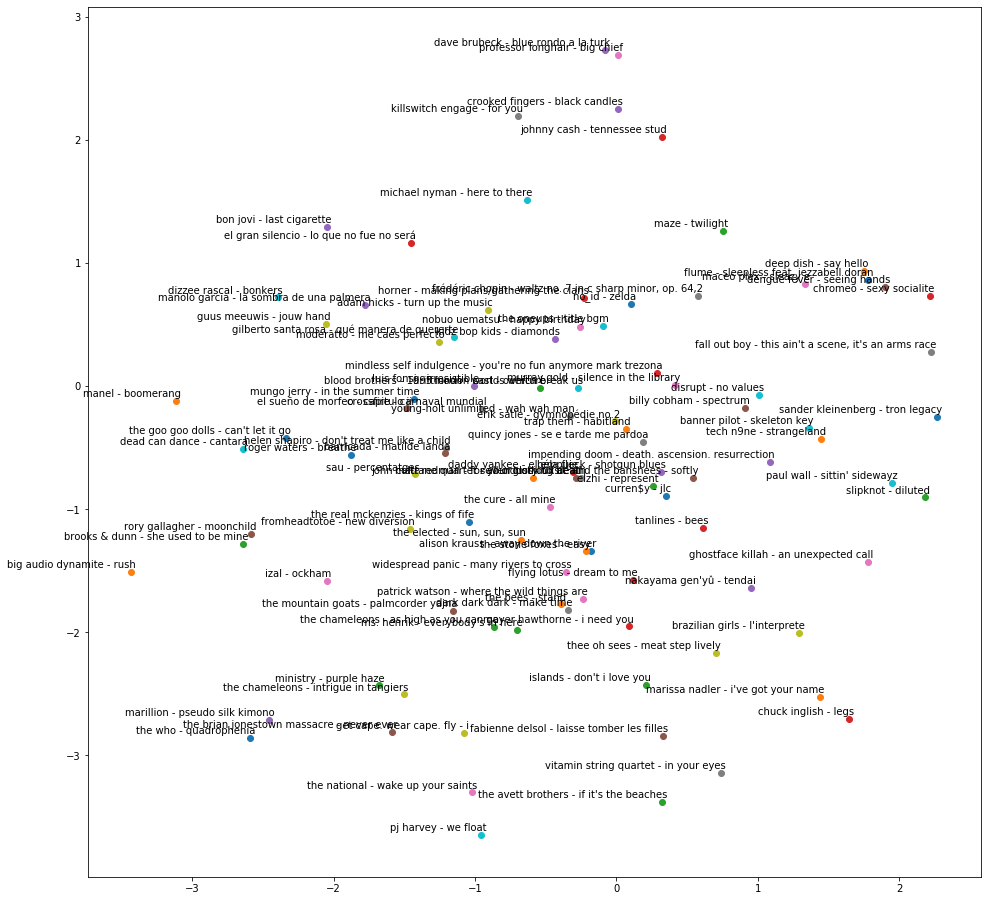

In [ ]:
def label_format(label, condition=0):
    if condition == 1:
        return label.split("-", 1)[0]
    elif condition == 2:
        return label.split("-", 1)[1]
    else:
        return label


plt.figure(figsize=(16, 16)) 

for i in range(len(X_tsne)):
    plt.scatter(X_tsne[i,0],X_tsne[i,1])
    plt.annotate(label_format(labels[i], 0),
                 xy=(X_tsne[i,0],X_tsne[i,1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [ ]:
#nep on train 
k = 100
hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_playlist(train, k)
display((hits/tries, ndgc/tries, tries, fails))

(0.38294071365761095, 0.1105024861948448, 108035, 42714)

In [ ]:
#nep on test
k = 100
hits, ndgc, tries, fails = test_HR_and_NDGC_one_task_per_playlist(test, k)
display((hits/tries, ndgc/tries, tries, fails))

(0.3370222475755847, 0.093950164974484, 26295, 11393)

## Appendix

In [ ]:
#sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram
#min_count (int, optional) – Ignores all words with total frequency lower than this.
#window (int, optional) – Maximum distance between the current and predicted word within a sentence.
#sample (float, optional) – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).

#hs ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training.
#If 0, and negative is non-zero, negative sampling will be used.

#negative (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many 
#“noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.

#model = gensim.models.Word2Vec(documents, min_count=1, workers=16, sg=1, size = 300, hs=1, window = 5)
#model.train(documents,total_examples=len(documents),epochs=1)

#window_size window-size
#it number of epochs 
#sample sub-sampling parameter
#power-alpha negative sampling distribution parameter

#window_size=3
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.0001 
#power_alpha=-0.5

#other
#size_embedding=50
#neg_sample=5
#workers=10
#min_count=5 #cold start?

#window_size=7
#it=20 #increasing this leads to returning words with wrong similarity
#sample=0.001 
#power_alpha=0.025

#size_embedding=50
#neg_sample=5
#workers=10
#min_count=2 #cold start?


#model = gensim.models.Word2Vec(test, size=size_embedding, window=window_size,
#                 min_count=min_count, workers=workers, sg=1, iter=it,
#                 sample=sample, negative=neg_sample, alpha=power_alpha)

#model.train(test,total_examples=len(test), epochs=model.iter)